## Import the necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle

## Load the data

In [2]:
# Load observational data (time, radial velocity, errors)
file_path = '/Users/nishron/Documents/Exoplanet Detection - RadVel/Data/RV_51Pegasi_Data.txt'
with open(file_path,'r') as file:
    lines = file.readlines()
    obs_t=[]
    obs_v=[]
    obs_verr=[]
    result=[obs_t,obs_v,obs_verr]
    for y in [0,1,2]:
        for x in lines:
            str = x.split('\t')[y]
            if str[-1]=='\n':
                str = str[:-1]
            result[y].append(str)
    file.close()
    obs_t.pop(0)
    obs_v.pop(0)
    obs_verr.pop(0)
    coln = []
    for z in obs_t:
        h = float(z) - 2450463.162419
        coln.append(h)
    obs_t=coln
    result[0]=obs_t
    for y in [0,1,2]:
        for x in range (0,len(result[y])):
            result[y][x]=float(result[y][x])

            
time = result[0]
radial_velocity = result[1]
errors = result[2]
print(result)

[[-2450460.4887690004, -2450460.353689, -2450460.202629, -2450459.535469, -2450459.429769, -2450459.261649, -2450458.554889, -2450458.3781290003, -2450458.255429, -2450457.557389, -2450457.2369790003, -2450451.5181190004, -2450451.3246190003, -2450450.5269190003, -2450450.296019, -2450449.538219, -2450449.332919, -2450448.519619, -2450448.4395190002, -2450448.3463190002, -2450448.258119, -2450447.536319, -2450447.415719, -2450447.297019, -2450446.5475190002, -2450446.403219, -2450446.3150190003, -2450445.428319, -2450445.318219, -2450444.546319, -2450444.397619, -2450444.3084190004, -2450443.5406190003, -2450443.4299190002, -2450443.315119, -2450442.548719, -2450442.422319, -2450442.3081190004, -2450441.547319, -2450441.500419, -2450441.456119, -2450439.563819, -2450439.5176190003, -2450439.472019, -2450439.436619, -2450438.5233190004, -2450438.436319, -2450438.345019, -2450437.5398190003, -2450437.4479190004, -2450437.400919, -2450436.544819, -2450436.511619, -2450436.460419, -2450436

## Define the model

In [3]:
# Define the model function for radial velocity
def model_radial_velocity(t, k, w, e, T0):
    theta = 2 * np.pi * (t - T0) / period
    return k * (np.cos(theta + w) + e * np.cos(w))

# Define a function to compute the true anomaly from mean anomaly
def true_anomaly(M, e):
    # Initial guess for E
    E = M
    
    # Iteratively solve Kepler's equation for E
    while True:
        E_new = M + e * np.sin(E)
        if np.abs(E_new - E) < 1e-6:
            break
        E = E_new
    
    # Compute the true anomaly from E
    f = 2 * np.arctan(np.sqrt((1 + e) / (1 - e)) * np.tan(E / 2))
    return f


## Phase folding the data

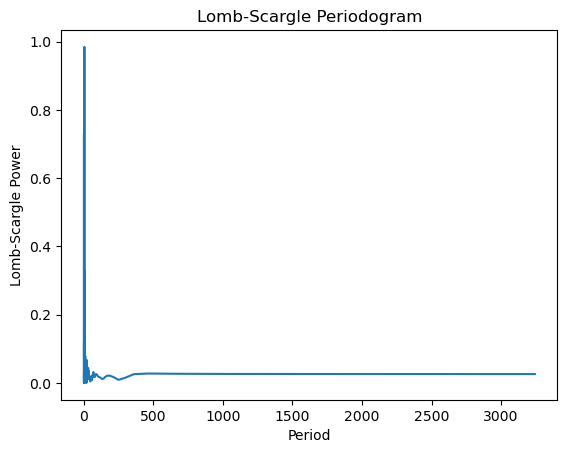

In [4]:
# Perform Lomb-Scargle periodogram analysis
frequency, power = LombScargle(time, radial_velocity, errors).autopower()
period = 1 / frequency[np.argmax(power)]

# Plot the periodogram
plt.plot(1/frequency, power)
plt.xlabel('Period')
plt.ylabel('Lomb-Scargle Power')
plt.title('Lomb-Scargle Periodogram')
plt.show()

# Folding the time series
folded_time = time % period
sort_index = np.argsort(folded_time)
folded_time = folded_time[sort_index]
radial_velocity = np.array(radial_velocity)
radial_velocity = radial_velocity[sort_index]

## Parameter Estimation

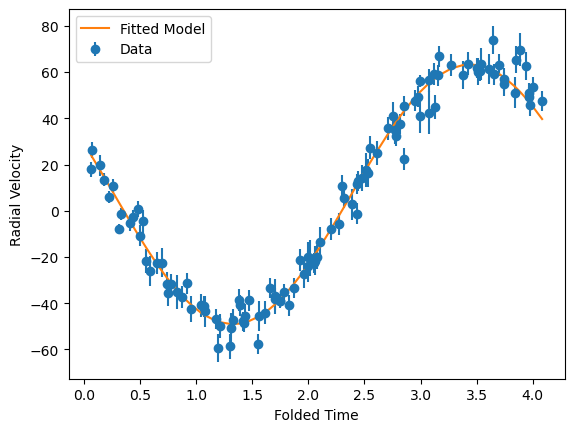

Estimated Semi-Amplitude (k): 56.18389075665685
Estimated Argument of Periastron (w): 0.8134875692024001
Estimated Eccentricity (e): 0.1846419987782849
Estimated Time of Periastron Passage (T0): -0.23853349488286563
Estimated Orbital Period: 4.227149282925734


In [7]:
# Initial guess for parameters [k, w, e, T0]
initial = [20.0, np.pi / 4.0, 0.1, 0.0]

# Bounds for parameter fitting [lower_bounds, upper_bounds]
bds = ([0, -np.pi, 0, -np.inf], [np.inf, np.pi, 1, np.inf])

# Perform curve fitting to estimate parameters
params, cov = curve_fit(model_radial_velocity, folded_time, radial_velocity, sigma=errors, p0=initial, bounds=bds)

# Extract estimated parameters
est_k, est_w, est_e, est_T0 = params



# Plot the folded data and fitted model
plt.errorbar(folded_time, radial_velocity, yerr=errors, fmt='o', label='Data')
plt.plot(folded_time, model_radial_velocity(folded_time, *params), label='Fitted Model')
plt.xlabel('Folded Time')
plt.ylabel('Radial Velocity')
plt.legend()
plt.show()

# Display estimated parameters
print("Estimated Semi-Amplitude (k):", est_k)
print("Estimated Argument of Periastron (w):", est_w)
print("Estimated Eccentricity (e):", est_e)
print("Estimated Time of Periastron Passage (T0):", est_T0)
print("Estimated Orbital Period:", period)


## Mass of the exoplanet

We can't directly calculate the mass of the exoplanet, but it's maximum mass which is given by the equation: $$m_p= \left(\frac{PM_*^2}{2 \pi G}\right)^{1/3}k_*\sqrt{1-e^2}$$

In [9]:
Sm = 1.98892*10**30
Da = 86400
Ju = 1.899 * 10**27

def mass_exoplanet(p,k,e,M):
    y = (p*M**2/(2*np.pi*6.674*10**(-11)))**(1/3)*k*np.sqrt(1-e**2)
    y = y/Ju
    return y

#51Pegasi is 1.11 times the mass of our sun
maximum_mass = mass_exoplanet(period*Da,est_k,est_e,1.11*Sm)

print(f'The maximum mass of the exoplanet is {round(maximum_mass,3)} jupiter masses')

The maximum mass of the exoplanet is 0.471 jupiter masses
